# Backtesting Prediction Models on Historical Data

Il est importang de backtester nos modèles sur des données historiques pour juger de leurs performances. Deux méthodes s'offrent à nous : un _train-test split_ classique, ou bien une _rolling window_ permettant de _fit_ le modèle successivement sur une fenêtre glissante ne laissant apparaître qu'une portion des données.

L'exemple ci-dessous est réalisé pour un modèle de régression linéaire ($\texttt{LinearRegression}$ de $\texttt{scikit-learn}$).

## Loading Data

In [94]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load and split the data into training and test sets
data = pd.read_csv('final_data.csv', sep=';')
data = data.drop('Unnamed: 0', axis=1)

data_champs = data[data['Libelle'] == 'AV_Champs_Elysees']
# data_convention = data[data['Libelle'] == 'Convention']
# data_peres = data[data['Libelle'] == 'Sts_Peres']

In [95]:
data_champs['Lag_7'] = data_champs['Débit horaire'].shift(7*24)
data_champs = data_champs.dropna()

/Users/Paul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Train Test Split

### Débit horaire

In [96]:
# Split the data into train and test sets
train, test = data_champs[data_champs.index < int(0.8*len(data_champs))], \
              data_champs[data_champs.index >= int(0.8*len(data_champs))]

# Extract the features and the variables
variables = ["Débit horaire"]
features = [col for col in data_champs.columns if col not in variables and 
            col not in ['Libelle', 'Date et heure de comptage', 'Etat trafic', "Taux d'occupation"]]

X_train, y_train = train[list(features)], train[list(variables)]
X_test, y_test = test[list(features)], test[list(variables)]

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print('RMSE:', np.sqrt(mse))

RMSE: 270.8533081175133


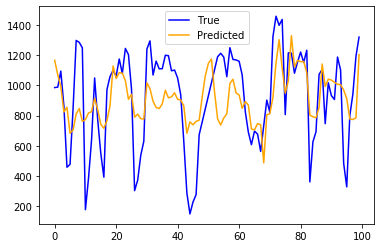

In [97]:
import matplotlib.pyplot as plt

plt.plot(range(len(y_test[:100])), y_test[:100], c='b', label='True')
plt.plot(range(len(y_pred[:100])), y_pred[:100], c='orange', label='Predicted')

plt.legend()
plt.show()

### Taux d'occupation

In [98]:
# Split the data into train and test sets
train, test = data_champs[data_champs.index < int(0.8*len(data_champs))], \
              data_champs[data_champs.index >= int(0.8*len(data_champs))]

# Extract the features and the variables
variables = ["Taux d'occupation"]
features = [col for col in data_champs.columns if col not in variables and 
            col not in ['Libelle', 'Date et heure de comptage', 'Etat trafic', "Débit horaire"]]

X_train, y_train = train[list(features)], train[list(variables)]
X_test, y_test = test[list(features)], test[list(variables)]

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print('RMSE:', np.sqrt(mse))

RMSE: 12.399284951324063


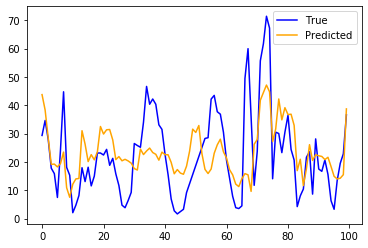

In [99]:
import matplotlib.pyplot as plt

plt.plot(range(len(y_test[:100])), y_test[:100], c='b', label='True')
plt.plot(range(len(y_pred[:100])), y_pred[:100], c='orange', label='Predicted')

plt.legend()
plt.show()

## Rolling Window

### Débit horaire

In [100]:
train, test = data_champs[data_champs.index < int(0.8*len(data_champs))], \
              data_champs[data_champs.index >= int(0.8*len(data_champs))]

# Extract the features and the variables
variables = ["Débit horaire"]
features = [col for col in data_champs.columns if col not in variables and 
            col not in ['Libelle', 'Date et heure de comptage', 'Etat trafic', "Taux d'occupation"]]

X_train, y_train = train[list(features)], train[list(variables)]
X_test, y_test = test[list(features)], test[list(variables)]

# Create the rolling window generator
# window_size = 24*31  # Size of the window to use for backtesting
# rolling_window = TimeSeriesSplit(n_splits=len(train) - window_size)
rolling_window = TimeSeriesSplit(n_splits=12)

model = LinearRegression()

# Loop through the data in the rolling window and fit the model
for train_index, test_index in rolling_window.split(train):
    window_train = train.loc[train_index[0]:train_index[-1]]
    window_test = train.loc[test_index[0]:test_index[-1]]
    
    X_window_train, y_window_train = window_train[list(features)], window_train[list(variables)]
    X_window_test, y_window_test = window_test[list(features)], window_test[list(variables)]
    
    # Fit the model to the data in the current window
    model.fit(X_window_train, y_window_train)
    
    # Evaluate the model on the data in the current window
    # y_window_pred = model.predict(X_window_test)
    # window_mse = mean_squared_error(y_window_test, y_window_pred)
    # print('Window RMSE:', np.sqrt(window_mse))
    
    # Evaluate the model on the test data
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    # model.evaluate(X_test, y_test)
    print('RMSE:', np.sqrt(mse))
    
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

RMSE: 319.25465285838334
RMSE: 279.6717680124063
RMSE: 284.2632511127205
RMSE: 276.71309503616243
RMSE: 275.2742086377149
RMSE: 275.39700053170054
RMSE: 275.41119057757766
RMSE: 273.7361902577364
RMSE: 272.38804907402
RMSE: 271.23335584833296
RMSE: 271.47612993006163
RMSE: 270.7094822890016


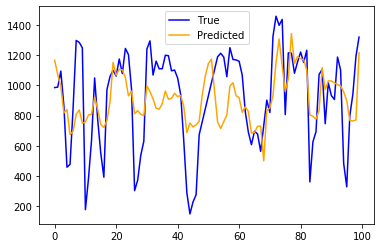

In [101]:
import matplotlib.pyplot as plt

plt.plot(range(len(y_test[:100])), y_test[:100], c='b', label='True')
plt.plot(range(len(y_pred[:100])), y_pred[:100], c='orange', label='Predicted')

plt.legend()
plt.show()

### Taux d'occupation

In [107]:
train, test = data_champs[data_champs.index < int(0.8*len(data_champs))], \
              data_champs[data_champs.index >= int(0.8*len(data_champs))]

# Extract the features and the variables
variables = ["Taux d'occupation"]
features = [col for col in data_champs.columns if col not in variables and 
            col not in ['Libelle', 'Date et heure de comptage', 'Etat trafic', "Débit horaire"]]

X_train, y_train = train[list(features)], train[list(variables)]
X_test, y_test = test[list(features)], test[list(variables)]

# Create the rolling window generator
# window_size = 24*31  # Size of the window to use for backtesting
# rolling_window = TimeSeriesSplit(n_splits=len(train) - window_size)
rolling_window = TimeSeriesSplit(n_splits=12)

model = LinearRegression()

# Loop through the data in the rolling window and fit the model
for train_index, test_index in rolling_window.split(train):
    window_train = train.loc[train_index[0]:train_index[-1]]
    window_test = train.loc[test_index[0]:test_index[-1]]
    
    X_window_train, y_window_train = window_train[list(features)], window_train[list(variables)]
    X_window_test, y_window_test = window_test[list(features)], window_test[list(variables)]
    
    # Fit the model to the data in the current window
    model.fit(X_window_train, y_window_train)
    
    # Evaluate the model on the data in the current window
    # y_window_pred = model.predict(X_window_test)
    # window_mse = mean_squared_error(y_window_test, y_window_pred)
    # print('Window RMSE:', np.sqrt(window_mse))
    
    # Evaluate the model on the test data
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    # model.evaluate(X_test, y_test)
    print('RMSE:', np.sqrt(mse))
    
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

RMSE: 14.219573584462418
RMSE: 13.135053641343141
RMSE: 12.900282615998824
RMSE: 12.680825918245947
RMSE: 12.611343891638302
RMSE: 12.645749838068404
RMSE: 12.731205241712498
RMSE: 12.688404083894053
RMSE: 12.668064833779013
RMSE: 12.60902166857671
RMSE: 12.572090656207415
RMSE: 12.48841381494814


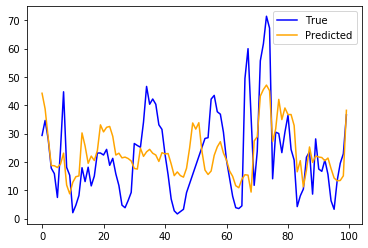

In [108]:
import matplotlib.pyplot as plt

plt.plot(range(len(y_test[:100])), y_test[:100], c='b', label='True')
plt.plot(range(len(y_pred[:100])), y_pred[:100], c='orange', label='Predicted')

plt.legend()
plt.show()